In [2]:
pip install Keras-Applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 195.4 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install keras_applications

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import tensorflow as tf

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
import keras
import keras_applications

In [7]:
from tensorflow.keras.applications import VGG16

In [8]:
conv_base =VGG16(weights ="imagenet",
                include_top=False,
                input_shape=(150,150,3))

2022-05-24 10:52:34.228945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 10:52:34.352456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 10:52:34.353207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 10:52:34.354480: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 2s 0us/step


In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [10]:
import os
import numpy as np


In [11]:
from keras_preprocessing.image import ImageDataGenerator

In [12]:
base_dir = '../input/brain-tumor-mri-dataset'
train_dir = os.path.join(base_dir,'Training')
test_dir = os.path.join(base_dir,'Testing')

In [13]:
datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 16


In [14]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,4))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        
        if i * batch_size >= sample_count:
            break
    return features, labels

In [15]:
train_features, train_labels = extract_features(train_dir, 5712)
test_features, test_labels = extract_features(test_dir, 1311)

Found 5712 images belonging to 4 classes.


2022-05-24 10:52:40.905309: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-24 10:52:41.834560: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Found 1311 images belonging to 4 classes.


In [16]:
X_train = np.reshape(train_features, (5712, 4 * 4 * 512))
y_train = train_labels

X_test = np.reshape(test_features, (1311, 4 * 4 * 512))
y_test = test_labels

In [17]:
np.save('tr_f_Dense201',X_train)
np.save('tr_l_Dense201',y_train)
np.save('tst_f_Dense201',X_test)
np.save('tst_l_Dense201',y_test)

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
import time

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Classifiers
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier, VotingClassifier)
from sklearn.naive_bayes import (GaussianNB, BernoulliNB)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report

In [19]:
classifiers = [
        
    ('LR', LogisticRegression(random_state=0, C = 10, multi_class = 'multinomial', solver= 'newton-cg')),
    ('LSVM', LinearSVC(random_state=0, C = 0.1, multi_class = 'crammer_singer')),
    ('KNN', KNeighborsClassifier(n_neighbors=1, p=2)),
    ('DT', DecisionTreeClassifier(criterion='entropy', max_depth=58)),
    ('RF', RandomForestClassifier(criterion='gini', max_depth=400)),
    ('AB', AdaBoostClassifier(n_estimators=50, learning_rate=1.0)),
    ('GNB', GaussianNB()),
    ('BNB', BernoulliNB()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('MLP', MLPClassifier())

    ]

In [20]:
ny_test = np.empty(1311)

for i in range(y_test.shape[0]): 
    for j in range(y_test.shape[1]):
        if y_test[i][j] == 1:
            ny_test[i] = j
            
ny_train = np.empty(5712)

for i in range(y_train.shape[0]): 
    for j in range(y_train.shape[1]):
        if y_train[i][j] == 1:
            ny_train[i] = j


In [21]:
print ("Akça")

Akça


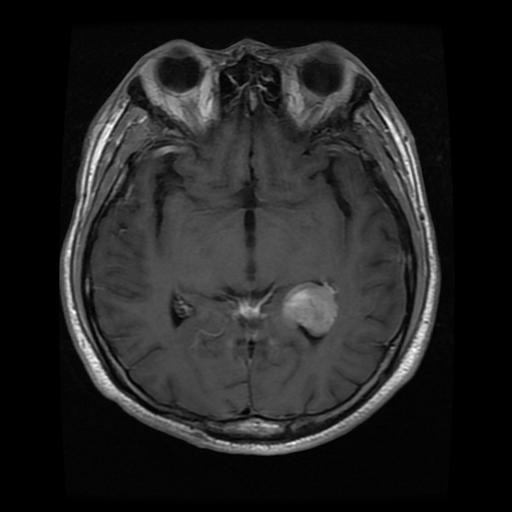

In [22]:
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm

model_builder = tf.keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path ="../input/brain-tumor-mri-dataset/Training/meningioma/Tr-meTr_0001.jpg"

display(Image(img_path))

In [23]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

49152/35363 [=========================================] - 0s 0us/step
Predicted: [('n01930112', 'nematode', 10.455297)]


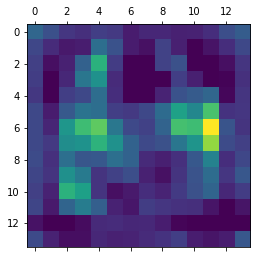

In [24]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

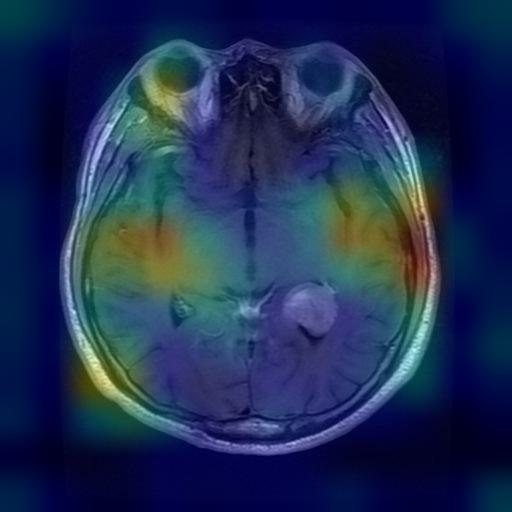

In [25]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

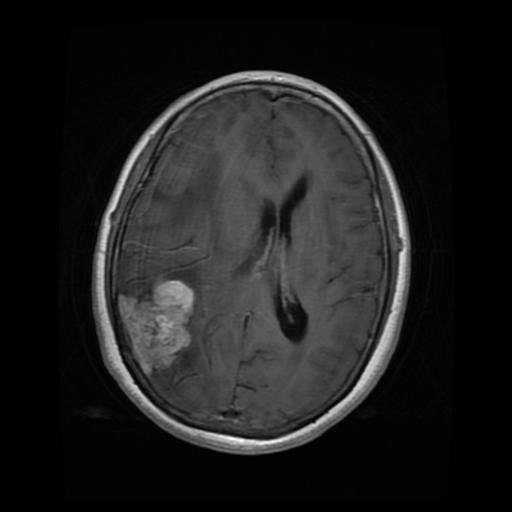

In [26]:
model_builder = tf.keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path ="../input/brain-tumor-mri-dataset/Training/meningioma/Tr-meTr_0007.jpg"

display(Image(img_path))

In [27]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Predicted: [('n02708093', 'analog_clock', 6.8384314)]


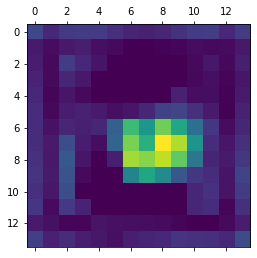

In [28]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

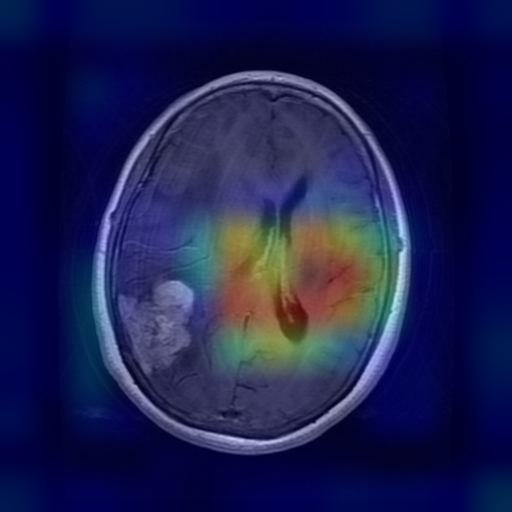

In [29]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

# meningioma

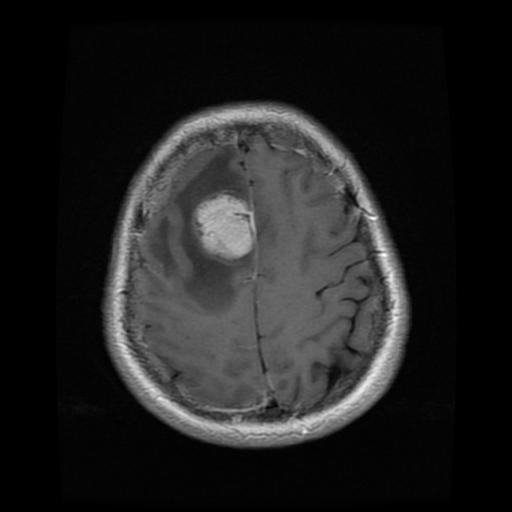

Predicted: [('n01930112', 'nematode', 11.637567)]


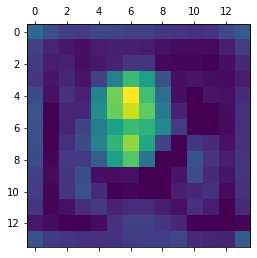

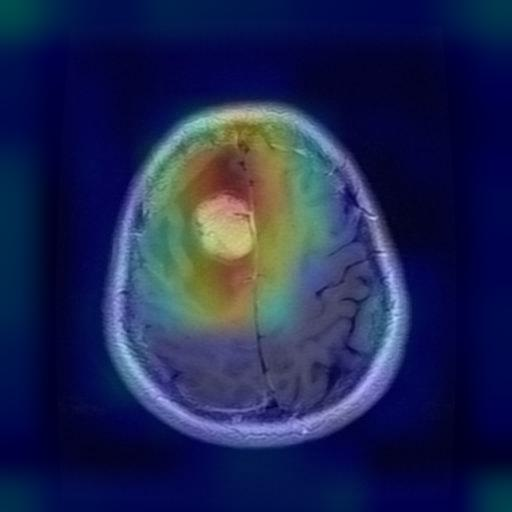

In [30]:
model_builder = tf.keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path ="../input/brain-tumor-mri-dataset/Training/meningioma/Tr-me_0019.jpg"

display(Image(img_path))

def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

# pituitary

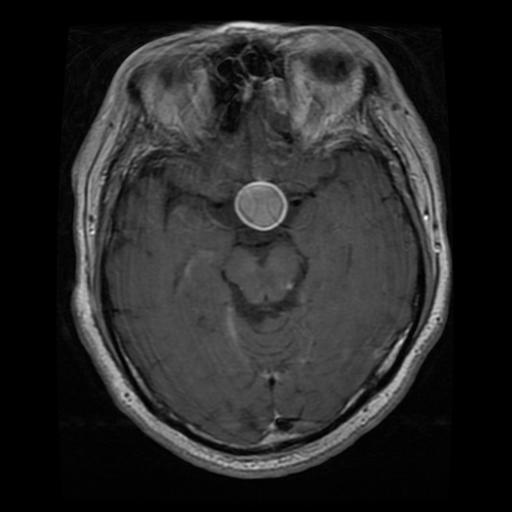

Predicted: [('n09229709', 'bubble', 7.4117146)]


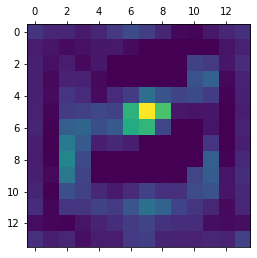

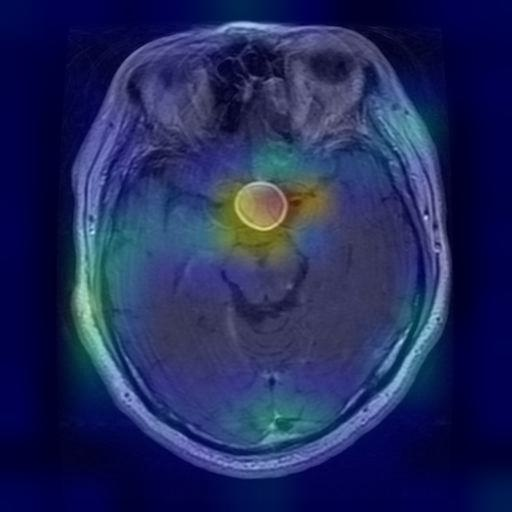

In [32]:
model_builder = tf.keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path ="../input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1105.jpg"

display(Image(img_path))

def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

# glioma

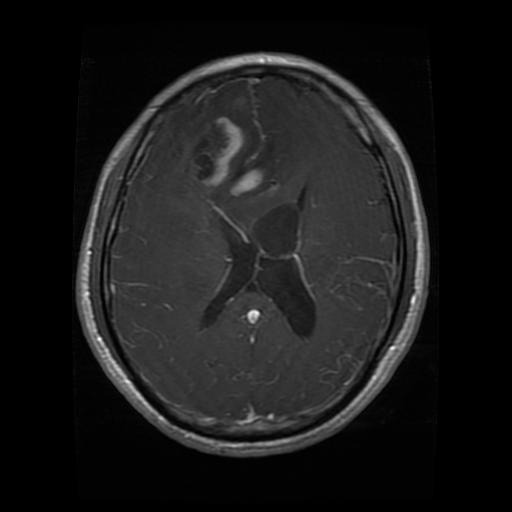

Predicted: [('n03929660', 'pick', 8.837002)]


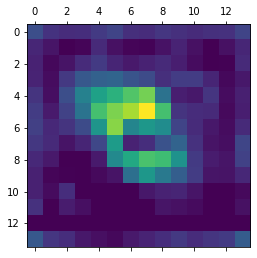

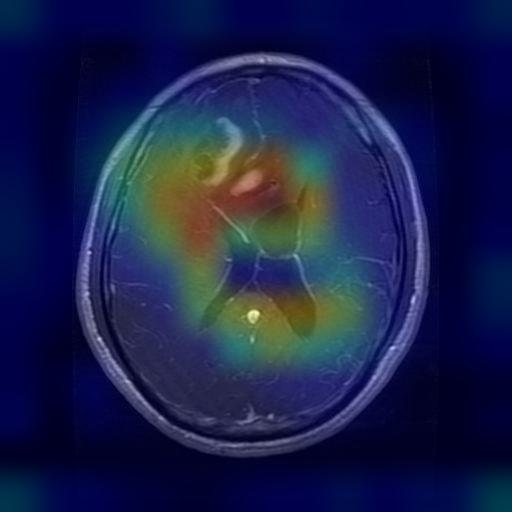

In [52]:
model_builder = tf.keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_conv_layer_name = "block5_conv3"

# The local path to our target image
img_path ="../input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0054.jpg"

display(Image(img_path))

def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [33]:
print (akça)

NameError: name 'akça' is not defined

In [ ]:
for clf_name, clf in classifiers:
    
    cross_val_scoree = np.empty(5)
   
    clf = make_pipeline(StandardScaler(with_mean = True, with_std = True), clf)
    clf.fit(X_train, ny_train)
    
    cv = ShuffleSplit(n_splits=5, random_state=0)
    
    cross_val_scoree = cross_val_score(clf, X_train, ny_train, cv=cv)
    
    print('Classifier: %s' % clf_name)
    print(cross_val_scoree)
    print('%0.4f accuracy with a standard deviation of %0.4f' % (np.mean(cross_val_scoree), np.std(cross_val_scoree)))
   
    
       
    train_sizes, train_scores, test_scores, fit_times, _  = learning_curve(estimator = clf,
                                                            X = X_train,
                                                            y = ny_train,
                                                            train_sizes=np.linspace(0.1, 1.0, 5),
                                                            cv = cv,
                                                            return_times = True,)
    
    
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
       
    plt.plot(train_sizes, train_mean, color='red', 
         marker='o', markersize=5, label='Training accuracy')
    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='red')
    
    
    plt.plot(train_sizes, test_mean, color='green', linestyle='--',
             marker='s', markersize=5, label='Cross-validation accuracy')
    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid()
    plt.title('Learning Curve of the {0}'.format(clf_name))
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.1, 1.05])
   # plt.savefig('Learning_Cur/{0}_LearningCurve_DenseML_ShoulderImp.png'.format(clf_name), dpi = 600)
    plt.show()
     

    plt.plot(fit_times_mean, test_mean, 'o-')
    plt.fill_between(fit_times_mean, test_mean - test_std,
                          test_mean + test_std, alpha=0.1)
    
    plt.grid()
    plt.title('Performance of the {0}'.format(clf_name))
    plt.xlabel('Fit times')
    plt.ylabel('Accuracy')
    #plt.savefig('Time_Perf/{0}_TimePerformance_DenseML_ShoulderImp.png'.format(clf_name), dpi = 600)
    plt.show()
    
    data = {'train_sizes':train_sizes,
            'train_mean':train_mean,
            'test_mean':test_mean,
            'fit_times_mean':fit_times_mean}

    df = pd.DataFrame(data)
    #df.to_csv('Scores/{0}_TrainingScores_DenseML_ShoulderImp.csv'.format(clf_name), index = False)

     
    t0 = time.time()
    prediction = clf.predict(X_test)
    t1 = time.time()
    testing_time = t1 - t0
    print('Testing time: %0.4fs' % testing_time)
    print(classification_report(ny_test, prediction, digits=4))
    print('*'*50,'\n')
    score = round(accuracy_score(ny_test, prediction),4) 
    cm1 = cm(ny_test, prediction)
    sns.heatmap(cm1, cmap='YlOrRd', annot=True, annot_kws={'size': 16}) 
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Accuracy Score: {0}'.format(score), size = 12)
    #plt.savefig('Conf_Mtx/{0}_ConfMtx_DenseML_ShoulderImp.png'.format(clf_name), dpi = 600)
    plt.show()